### Loading Packages and Data

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [3]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/18_adjusting_inertia/alabama/2023_07_19_11_11_52/count_data

deaths.csv                       risk_exposure_time.hdf
deaths.hdf                       sbp_medication_person_time.csv
healthcare_visits.csv            sbp_medication_person_time.hdf
healthcare_visits.hdf            state_person_time.csv
intervention_person_time.csv     state_person_time.hdf
intervention_person_time.hdf     transition_count.csv
ldlc_medication_person_time.csv  transition_count.hdf
ldlc_medication_person_time.hdf  ylds.csv
polypill_person_time.csv         ylds.hdf
polypill_person_time.hdf         ylls.csv
risk_exposure_time.csv           ylls.hdf


In [4]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/18_adjusting_inertia/alabama/2023_07_19_11_11_52/count_data/'

### Exploring Data

In [5]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
#deaths = deaths.loc[deaths.age != '25_to_29']
deaths.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,age,value
0,0,Female,2021,acute_ischemic_stroke,deaths,29,baseline,25_to_29,0
1,1,Female,2021,acute_ischemic_stroke,deaths,29,baseline,30_to_34,0
2,2,Female,2021,acute_ischemic_stroke,deaths,29,baseline,35_to_39,0
3,3,Female,2021,acute_ischemic_stroke,deaths,29,baseline,40_to_44,0
4,4,Female,2021,acute_ischemic_stroke,deaths,29,baseline,45_to_49,0


In [6]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
person_time.value.sum()

7367377.938398356

## Death Counts

In [7]:
deaths_all = deaths.groupby(['age', 'sex', 'year','input_draw']).value.sum().reset_index()
deaths_all = deaths_all.loc[deaths_all.year > 2022]
deaths_all.head()

,age,sex,year,input_draw,value
20,25_to_29,Female,2023,29,1
21,25_to_29,Female,2023,232,1
22,25_to_29,Female,2023,357,1
23,25_to_29,Female,2023,394,2
24,25_to_29,Female,2023,602,2


In [37]:
result_summary_deaths = (deaths_all
                      .groupby(['age', 'sex', 'year'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary_deaths.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,1.9,0.225,5.325
1,25_to_29,Female,2024,2.3,0.000,5.775
2,25_to_29,Female,2025,1.3,0.000,3.775
3,25_to_29,Female,2026,2.8,1.225,6.325
4,25_to_29,Female,2027,1.7,0.000,4.000


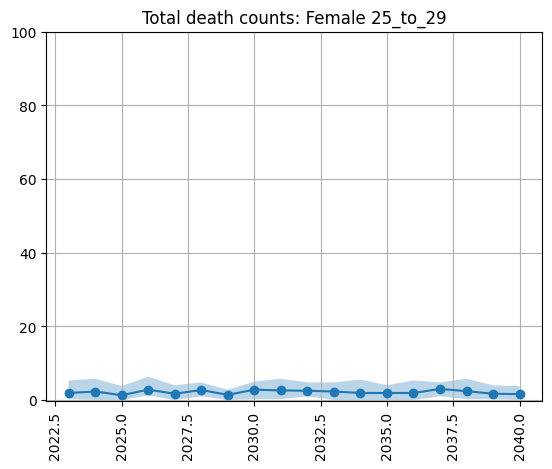

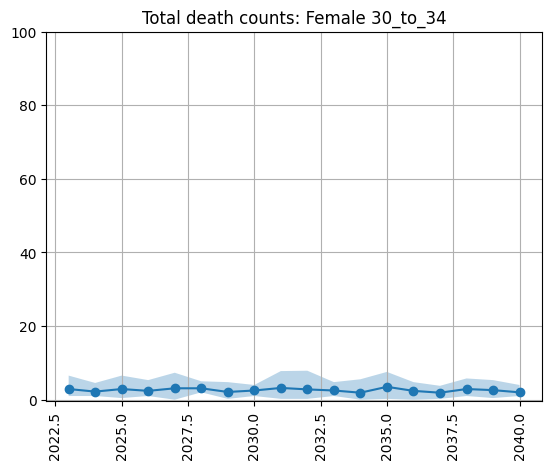

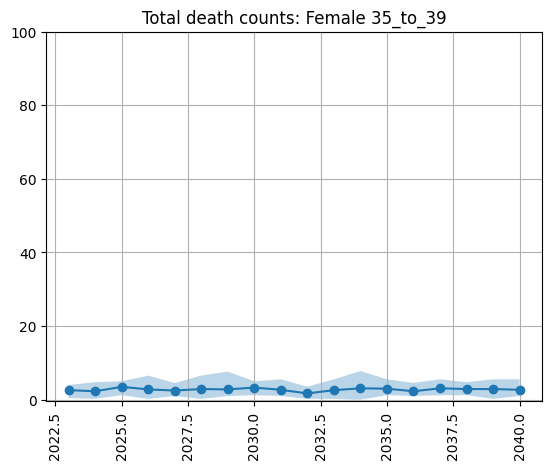

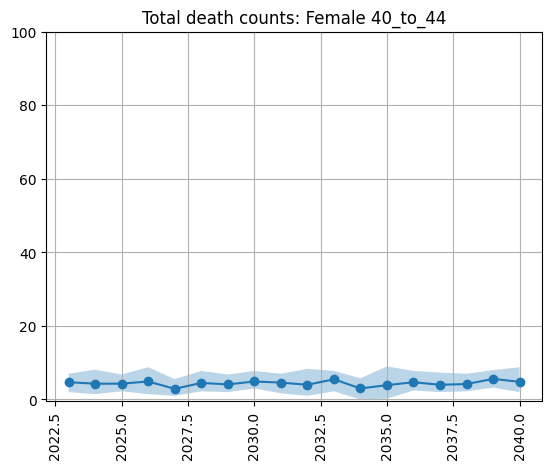

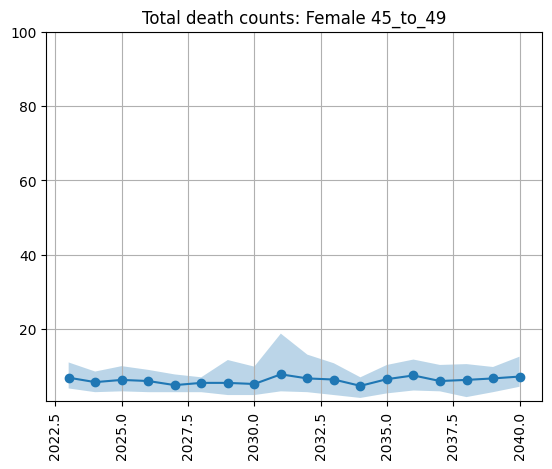

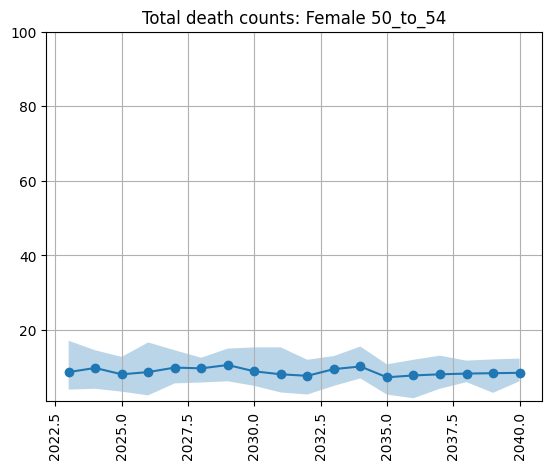

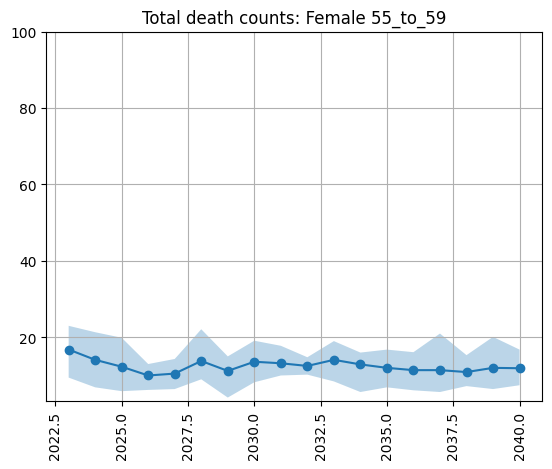

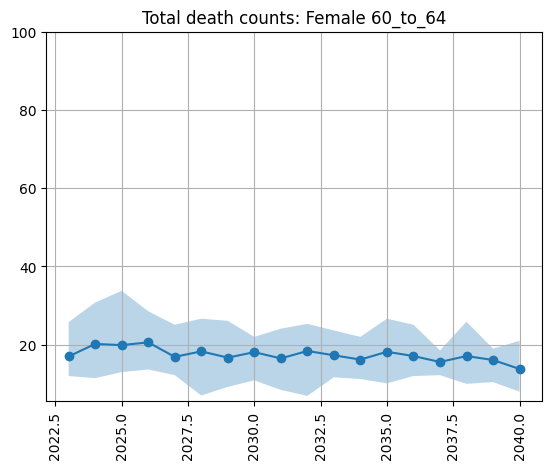

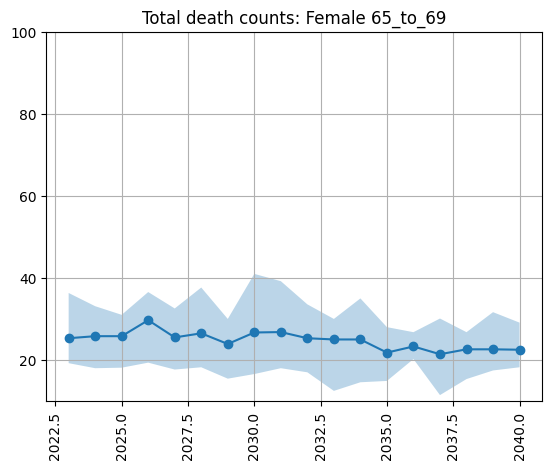

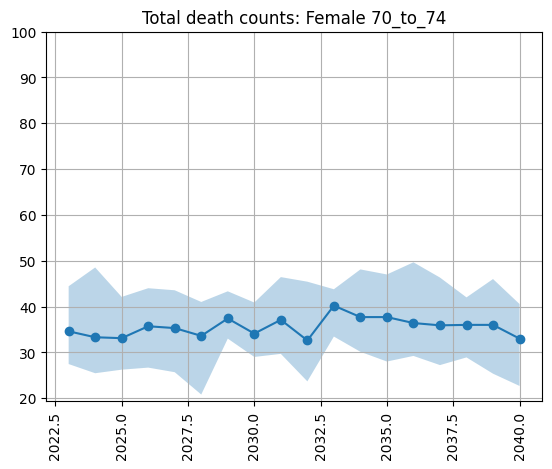

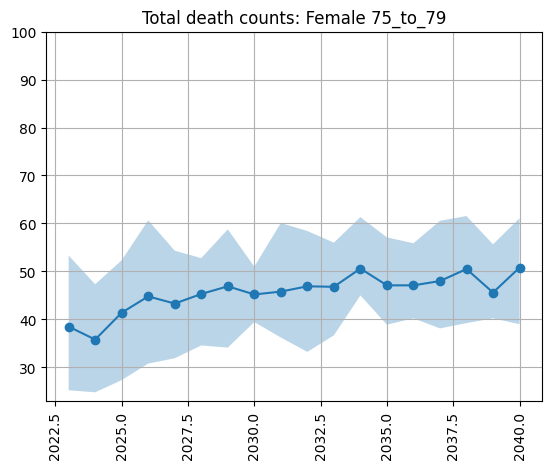

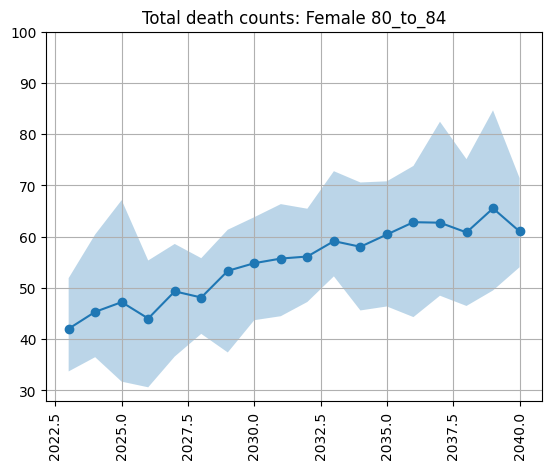

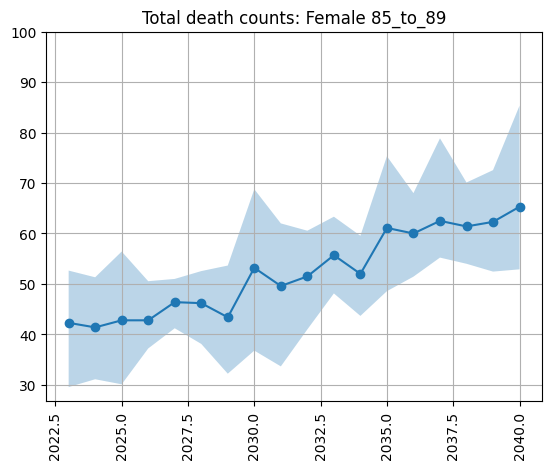

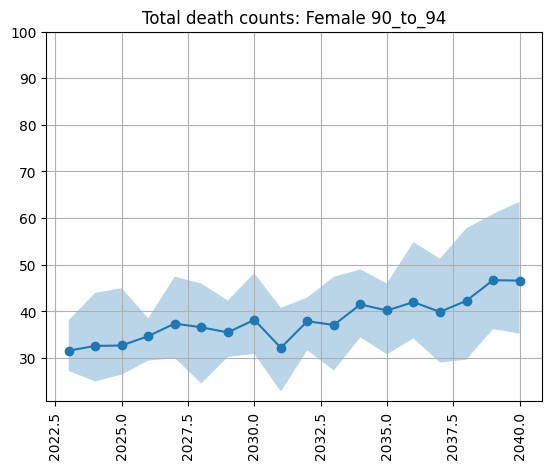

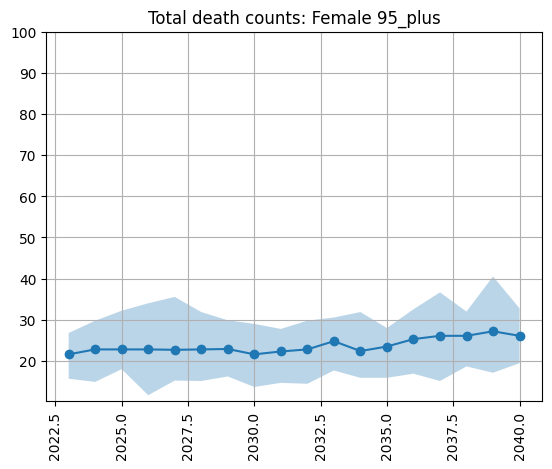

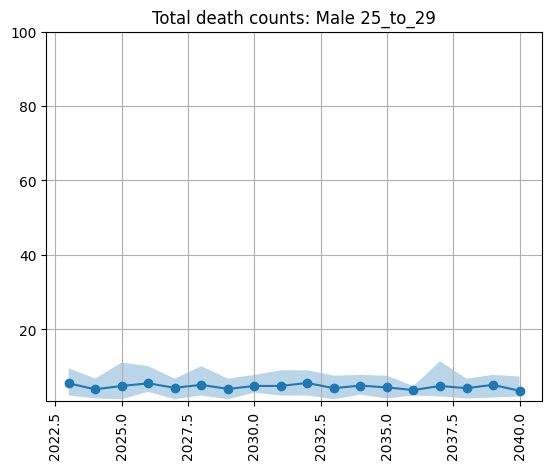

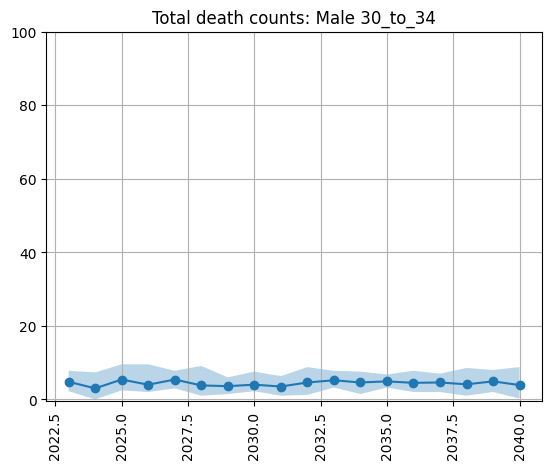

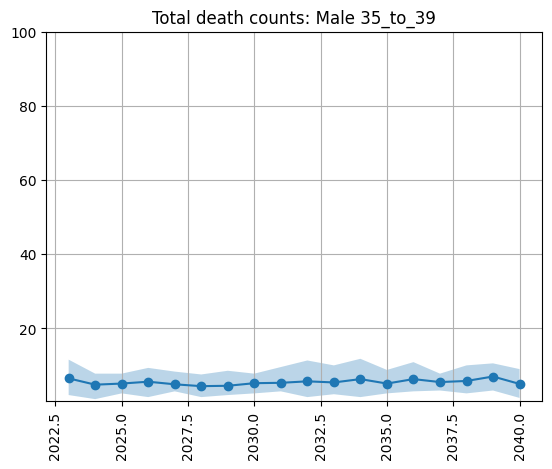

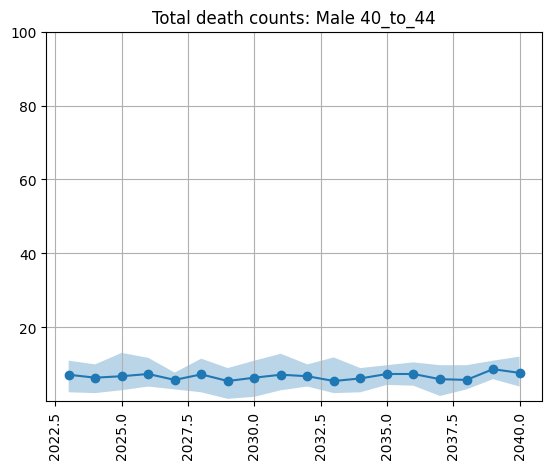

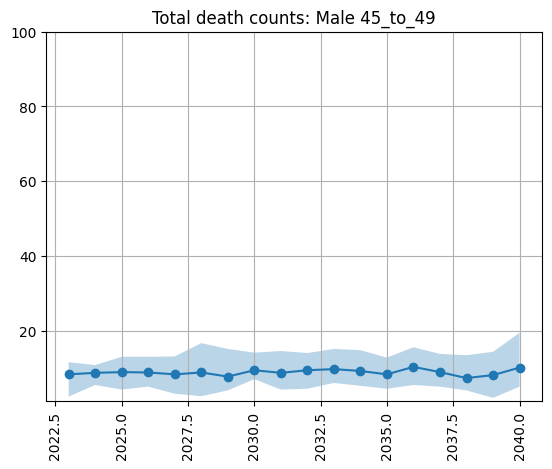

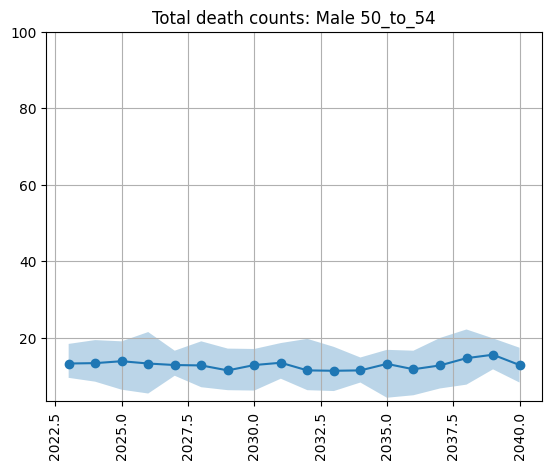

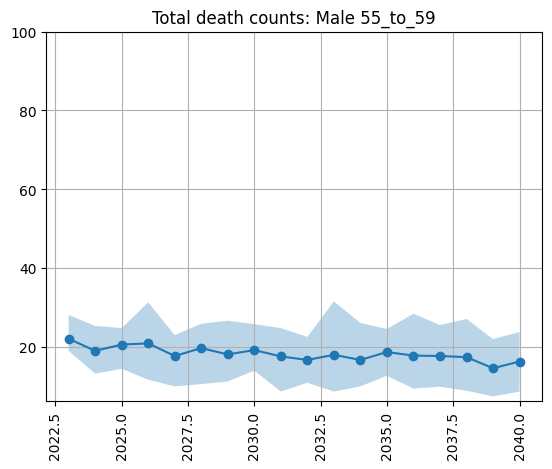

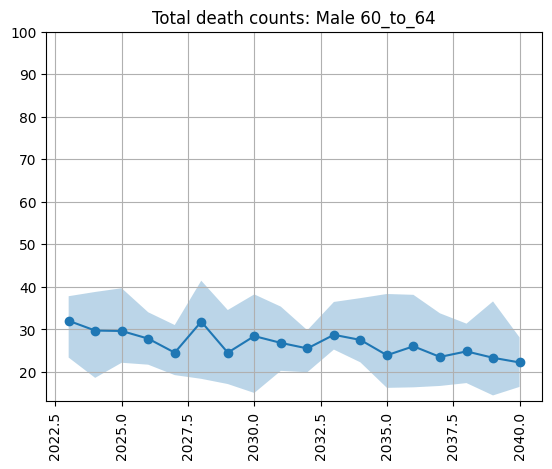

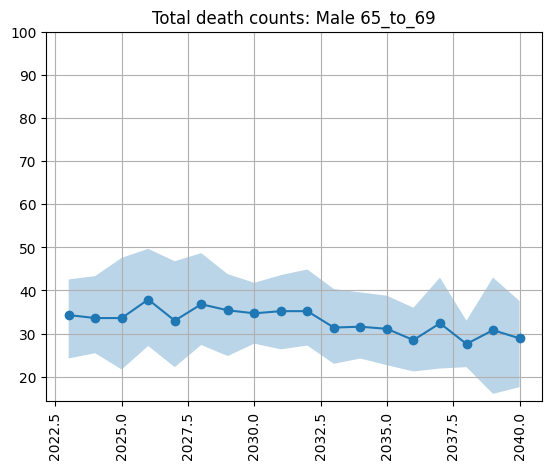

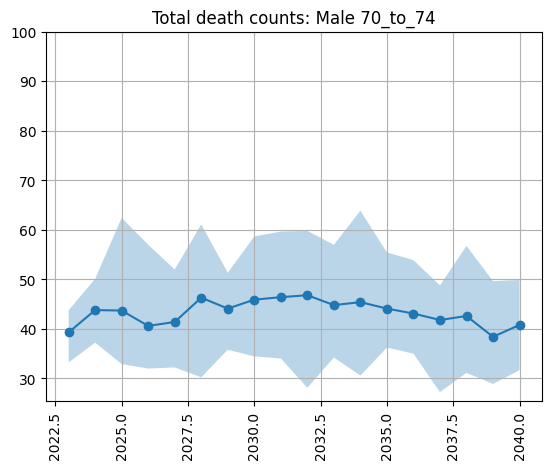

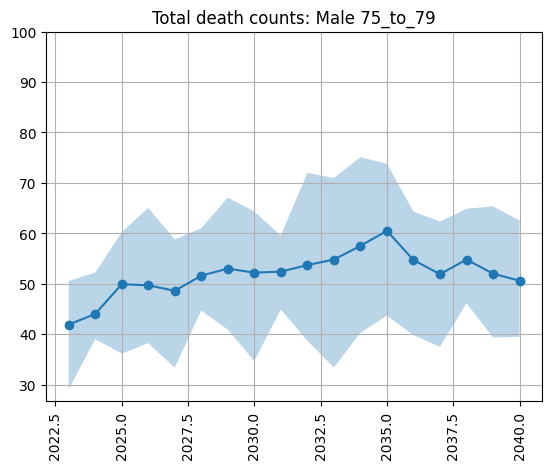

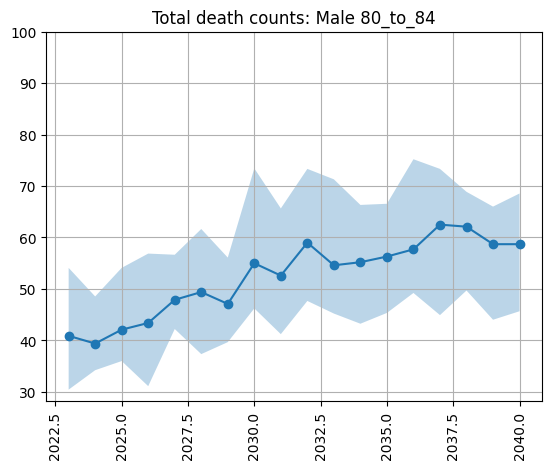

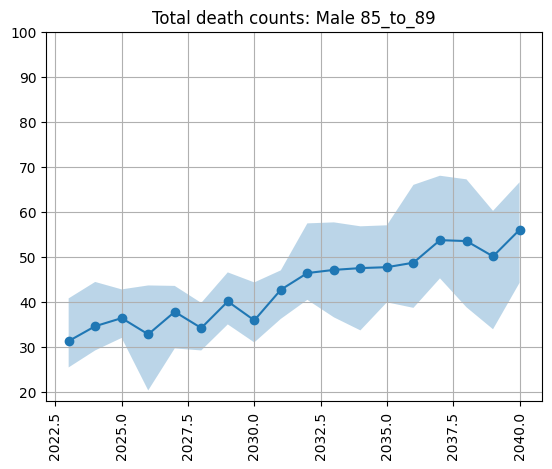

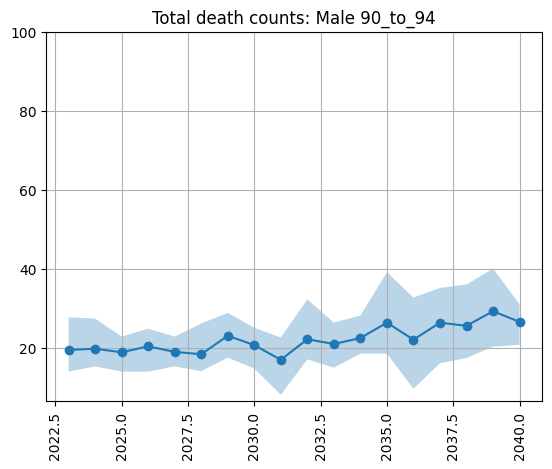

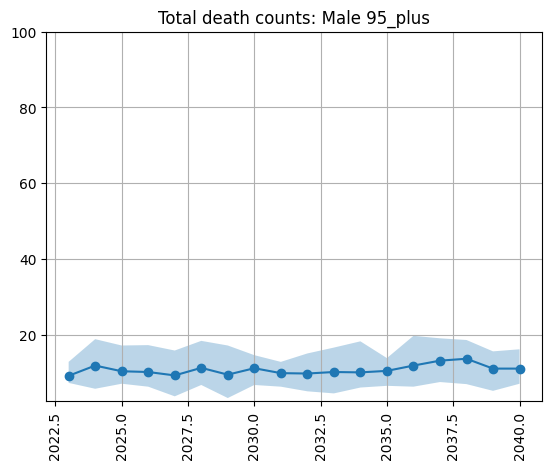

In [22]:
#%%capture 
from matplotlib.backends.backend_pdf import PdfPages # PDF package

with PdfPages('total_mortality_count_07212023.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for age in result_summary.age.unique():
            plt.figure()             
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Total death counts: {sex} {age}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=100)
            plt.grid()
            plt.xlabel('Year')
            plt.ylabel('Total Deaths')
            pdf.savefig(bbox_inches='tight')

## Person Time

In [17]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year', 'input_draw']).ptvalue.sum().reset_index()
per_time_group = per_time_group.loc[per_time_group.year > 2022]
per_time_group.head()

,age,sex,year,input_draw,ptvalue
20,25_to_29,Female,2023,29,1833.089665
21,25_to_29,Female,2023,232,1769.308693
22,25_to_29,Female,2023,357,1779.887748
23,25_to_29,Female,2023,394,1746.694045
24,25_to_29,Female,2023,602,1774.904860


In [18]:
per_time_summ = (per_time_group
                      .groupby(['age','sex', 'year'])
                      .ptvalue.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
per_time_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,1776.001095,1720.675702,1842.536071
1,25_to_29,Female,2024,1751.278303,1706.434223,1810.641752
2,25_to_29,Female,2025,1742.853388,1708.168652,1792.203149
3,25_to_29,Female,2026,1743.627652,1717.689802,1790.367146
4,25_to_29,Female,2027,1746.540726,1707.547707,1795.982478


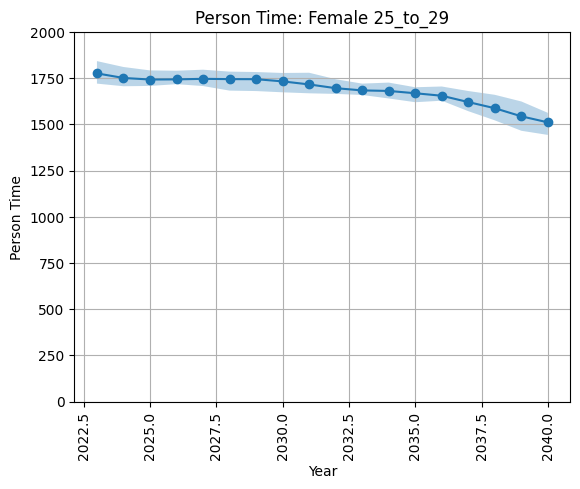

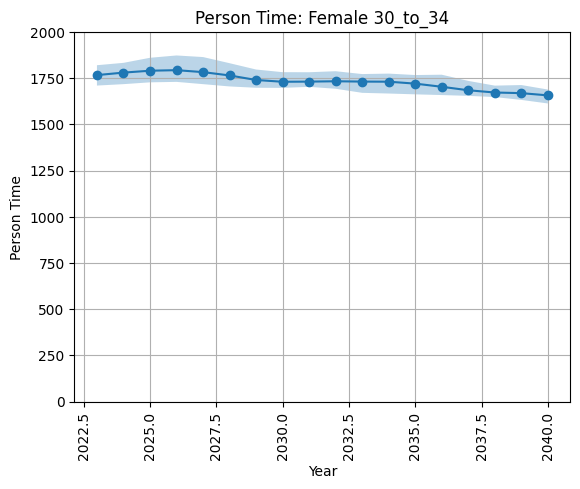

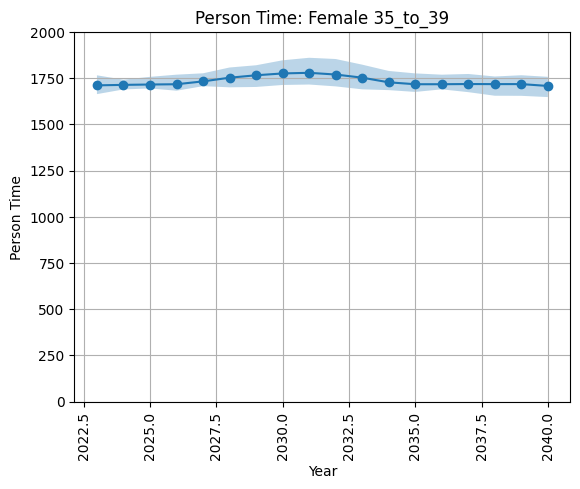

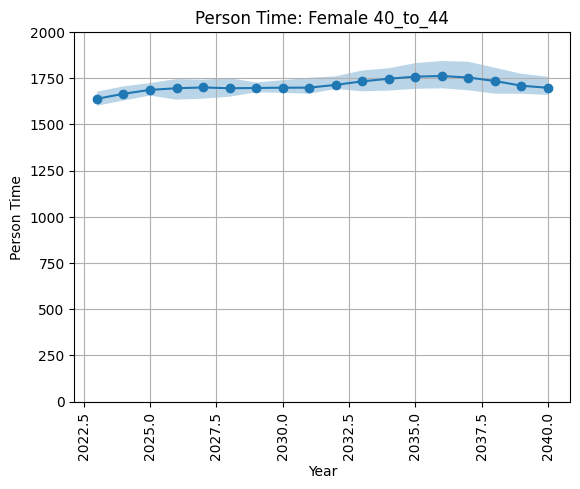

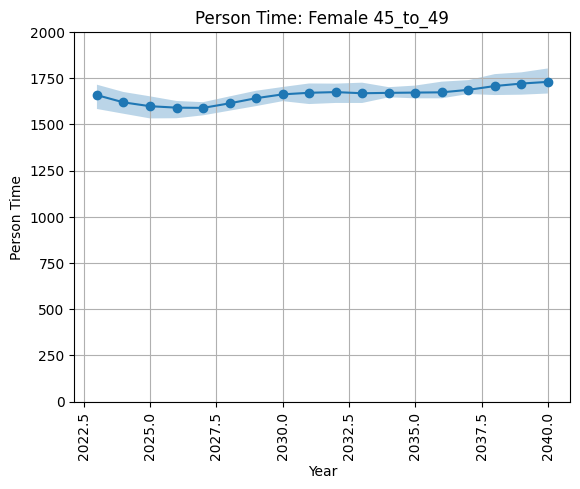

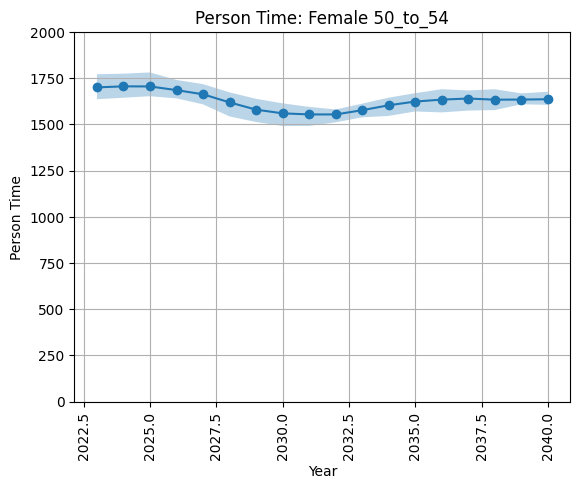

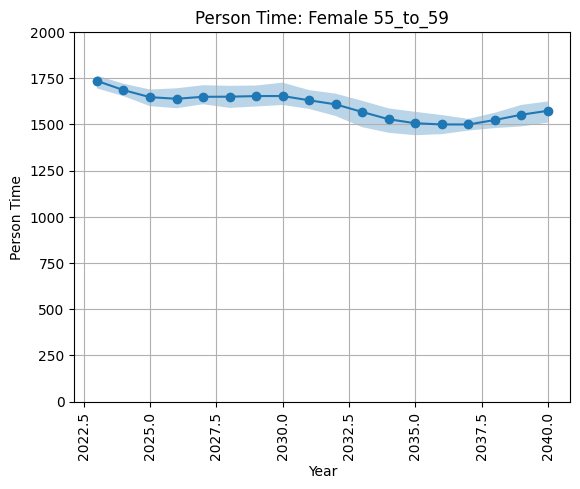

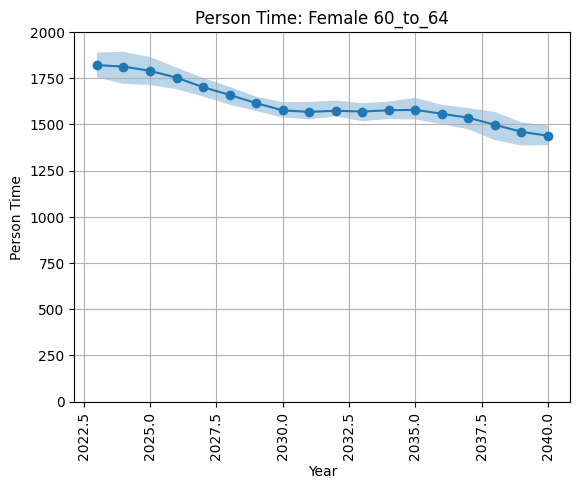

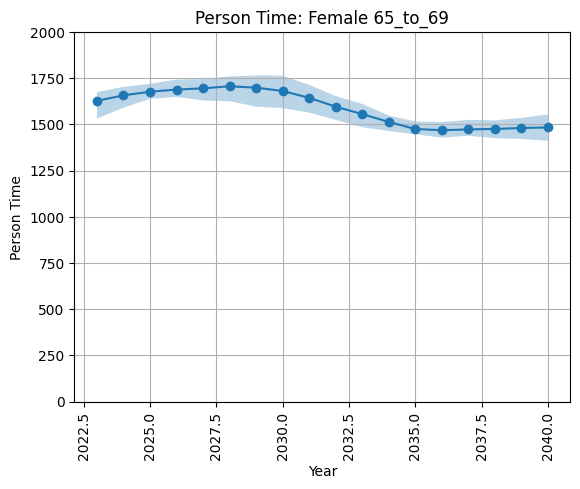

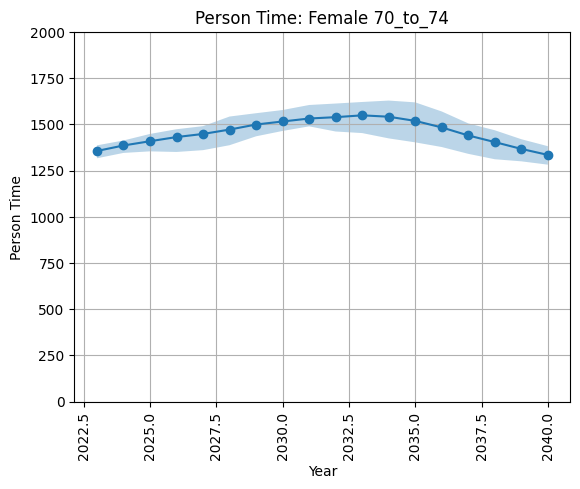

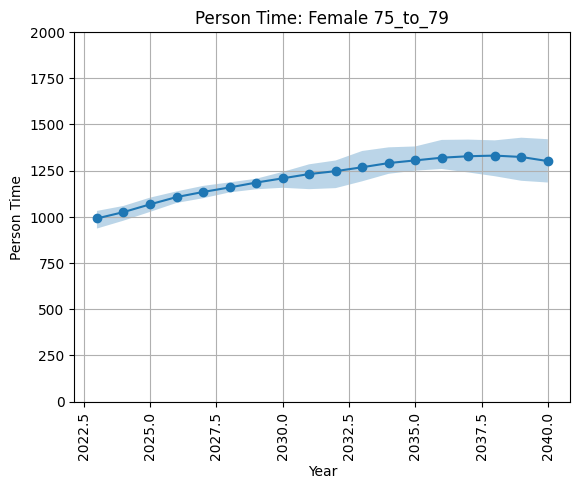

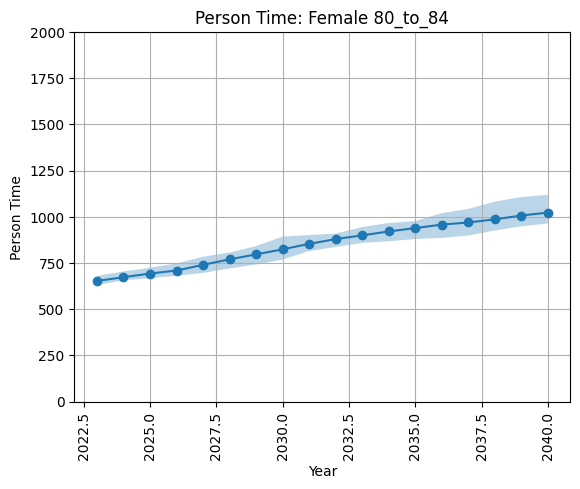

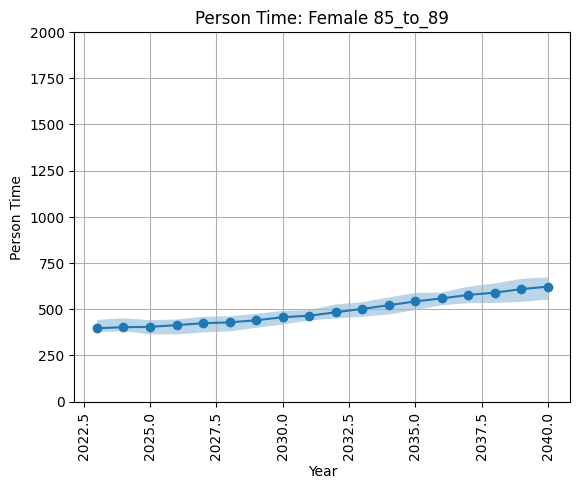

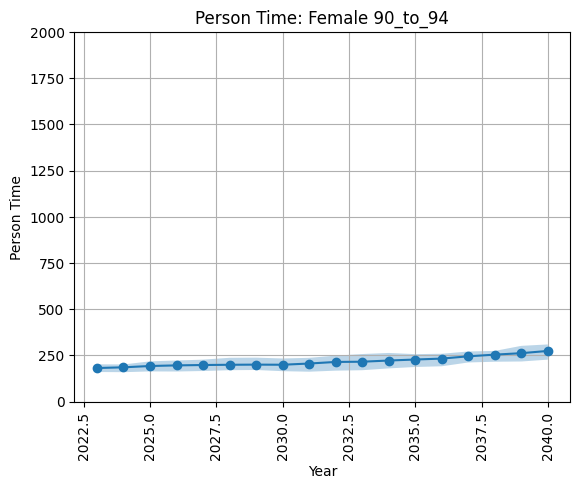

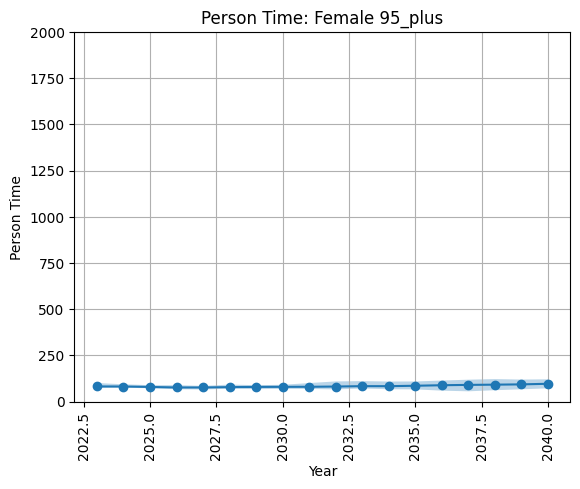

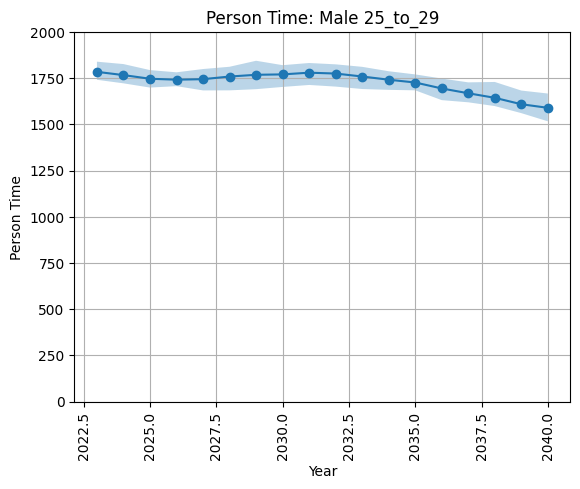

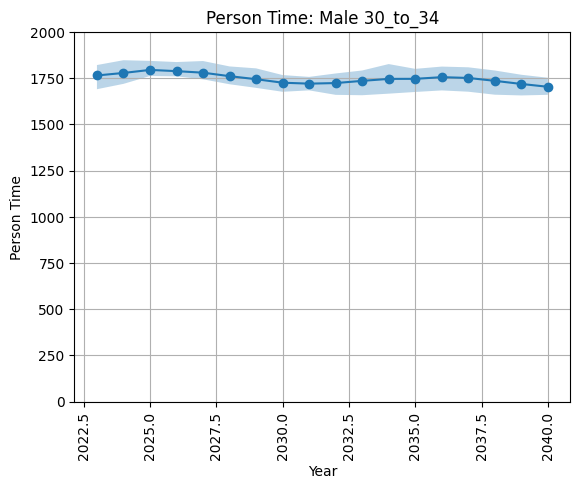

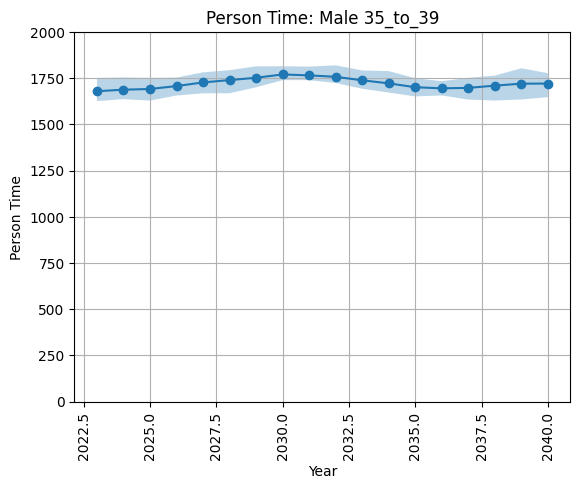

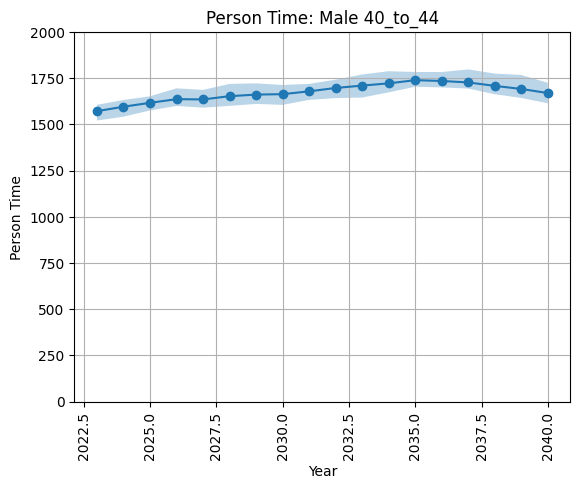

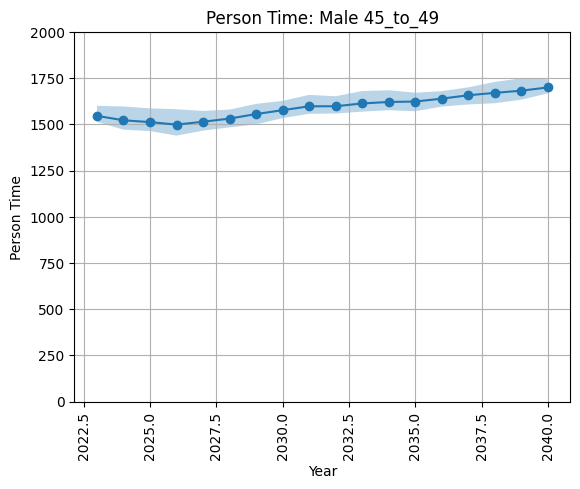

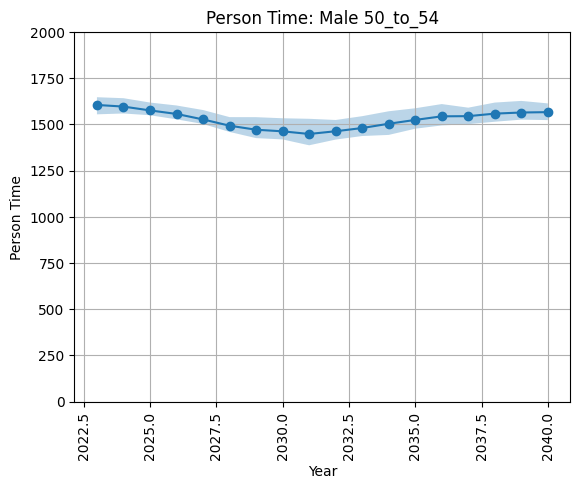

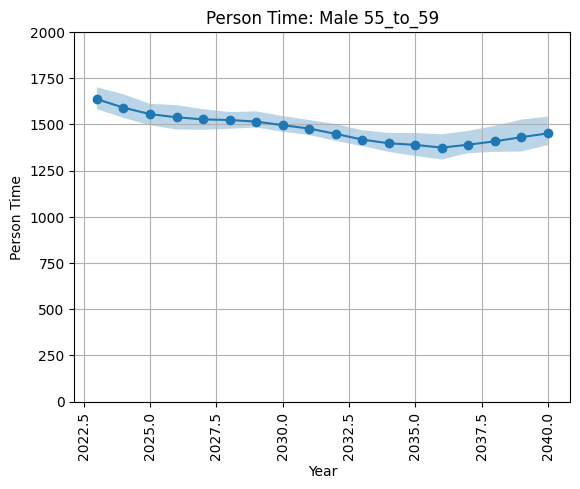

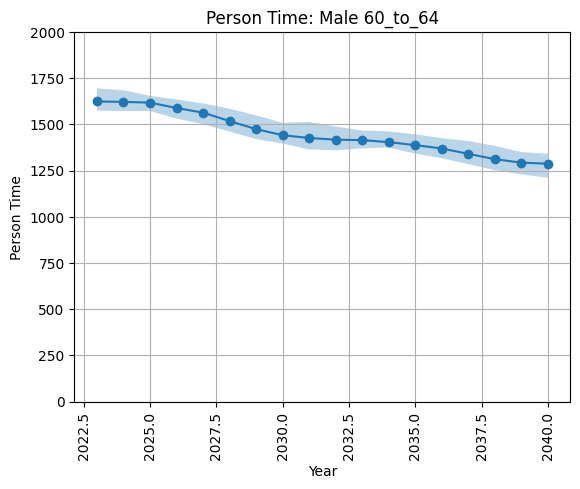

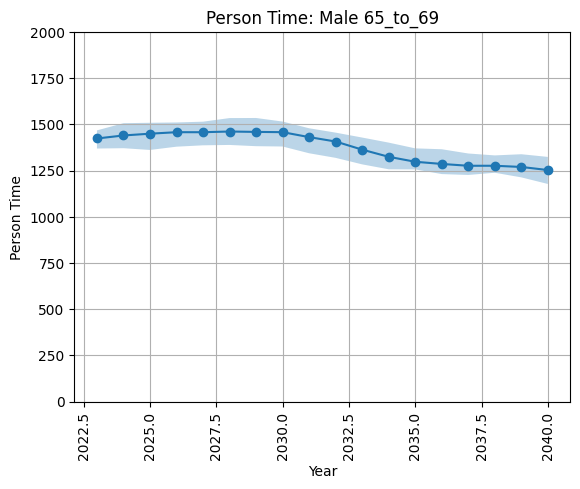

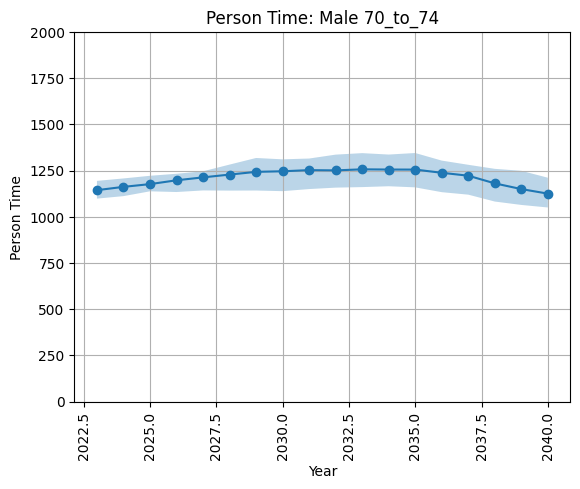

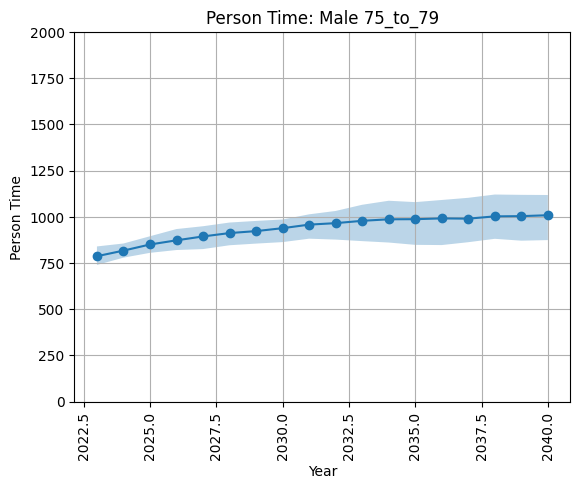

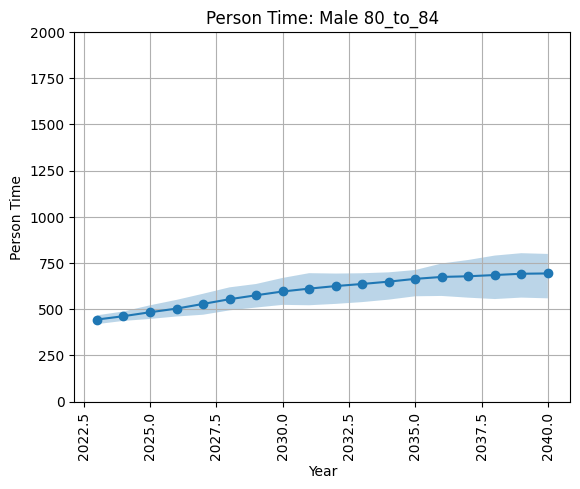

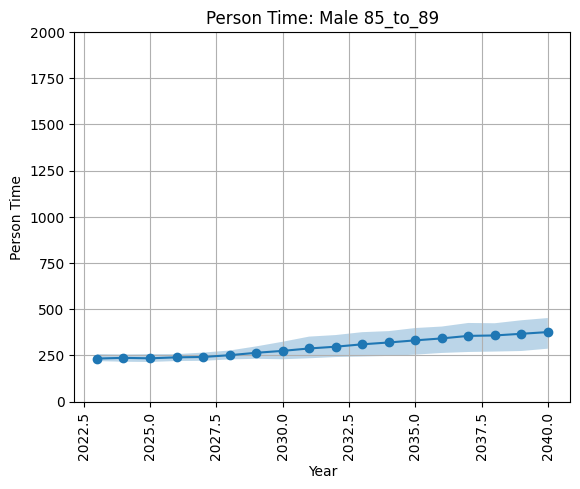

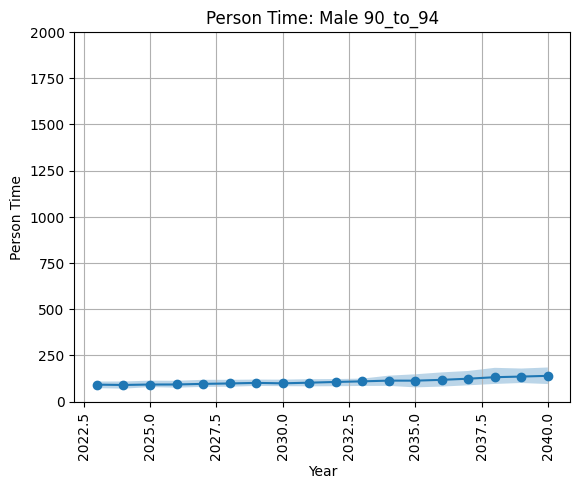

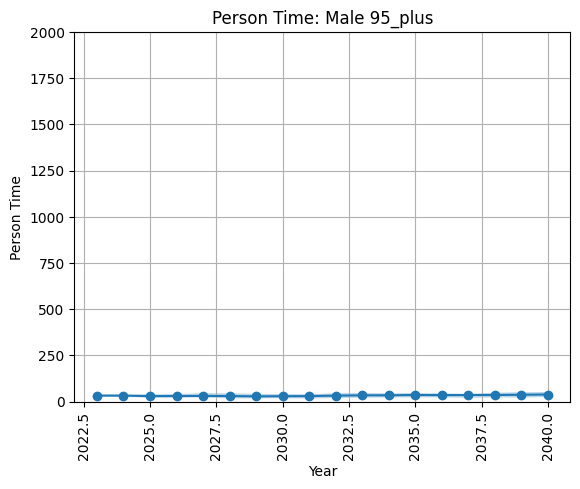

In [35]:
with PdfPages('person_time_07212023.pdf') as pdf:
    for sex in per_time_summ.sex.unique():
        for age in per_time_summ.age.unique():
            plt.figure() 
            subdata = per_time_summ.loc[(per_time_summ.sex==sex) & (per_time_summ.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Person Time: {sex} {age}') 
            plt.xticks(rotation=90) 
            plt.ylim(0,2000)
            plt.grid()
            plt.xlabel('Year')
            plt.ylabel('Person Time')
            pdf.savefig(bbox_inches='tight')

## ACMR Graphs

In [26]:
results_rate = pd.concat([deaths_all, per_time_group.ptvalue], axis=1)
results_rate['mean_rate'] = results_rate['value'] / results_rate['ptvalue']
result_summary = (results_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,Female,2023,0.001085,0.000123,0.003092
1,25_to_29,Female,2024,0.001309,0.000000,0.003320
2,25_to_29,Female,2025,0.000747,0.000000,0.002189
3,25_to_29,Female,2026,0.001610,0.000685,0.003638
4,25_to_29,Female,2027,0.000980,0.000000,0.002309


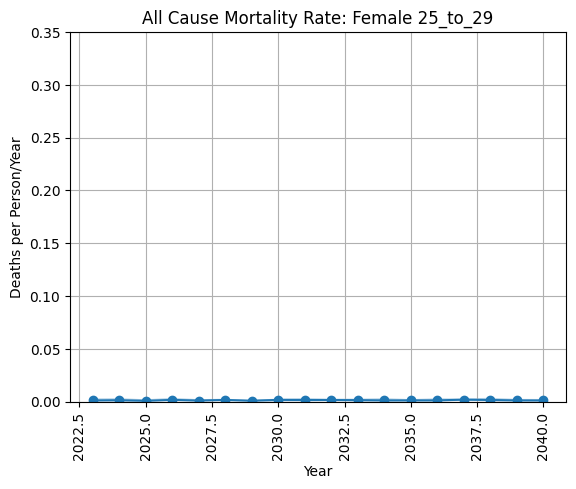

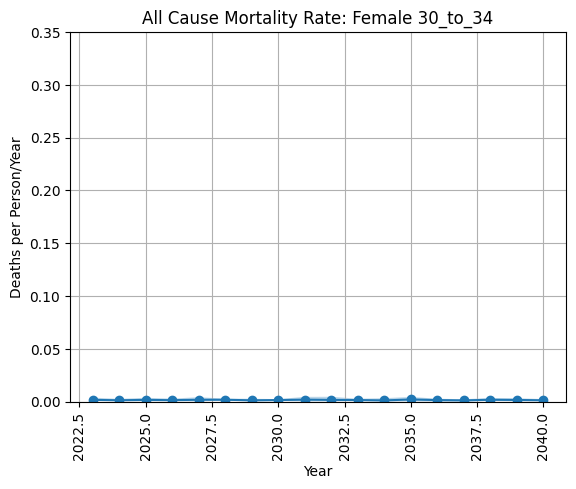

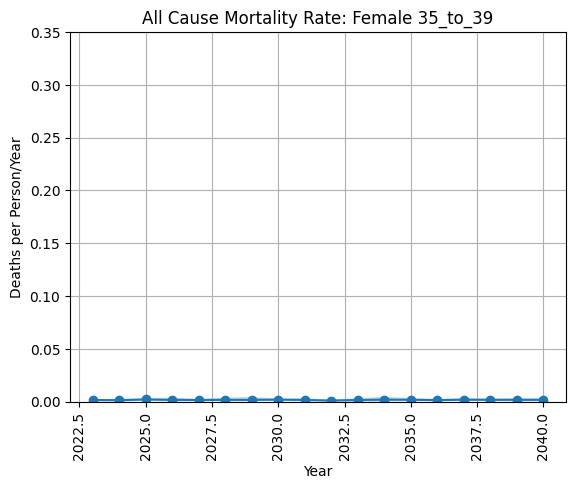

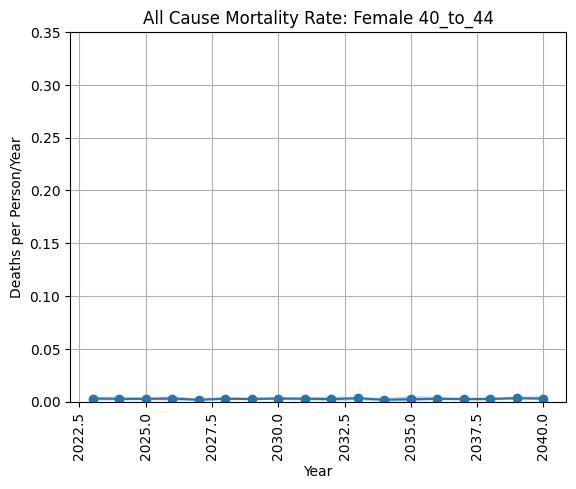

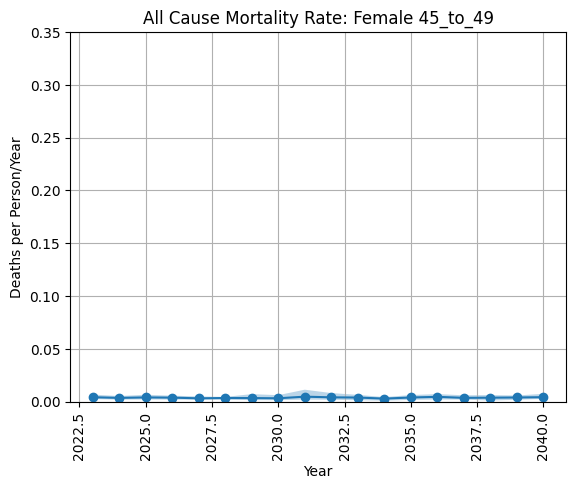

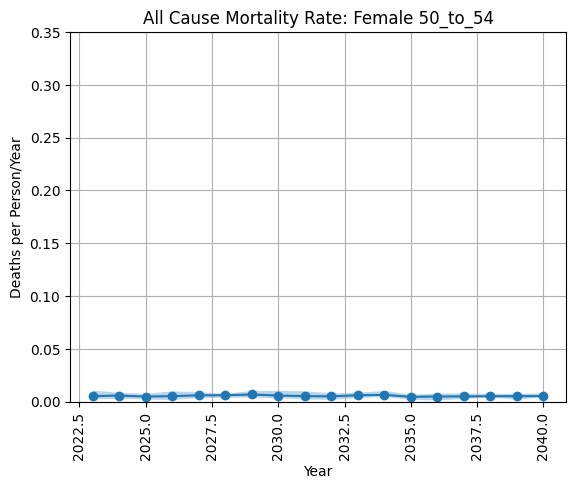

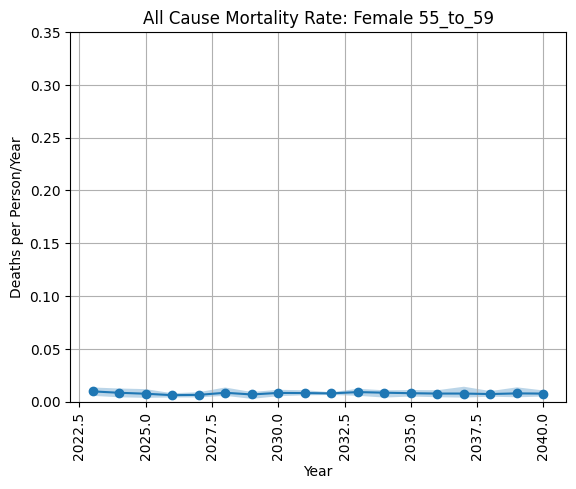

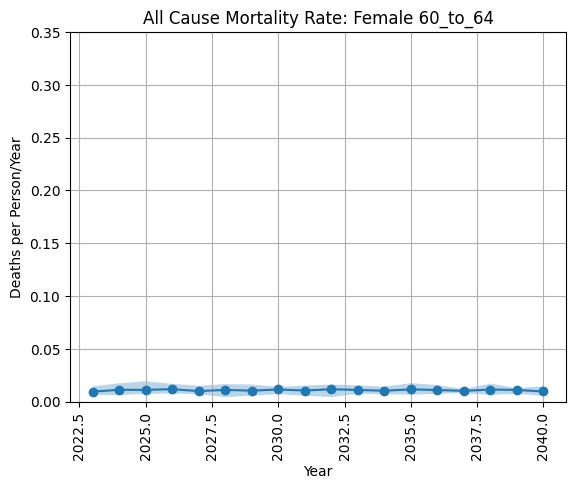

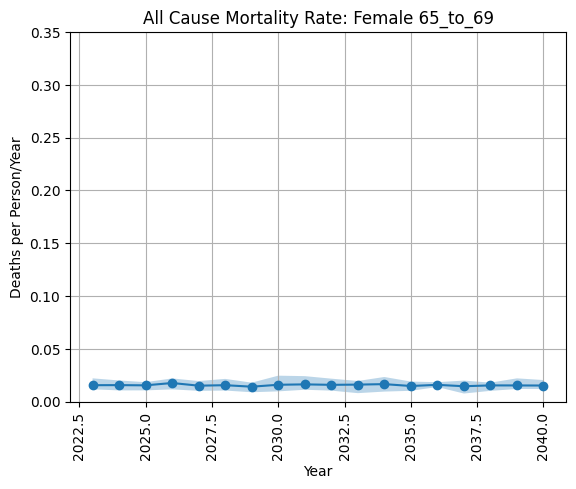

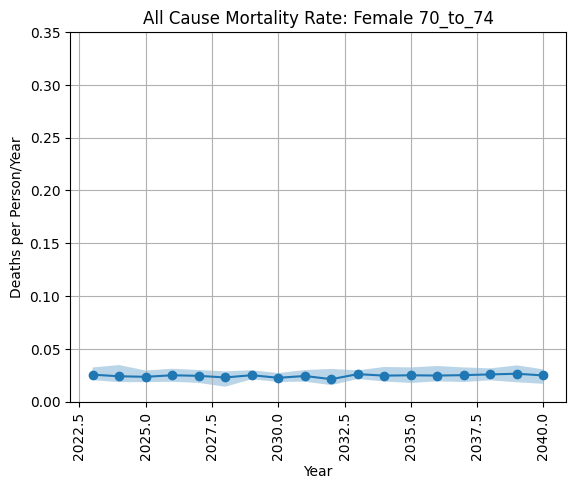

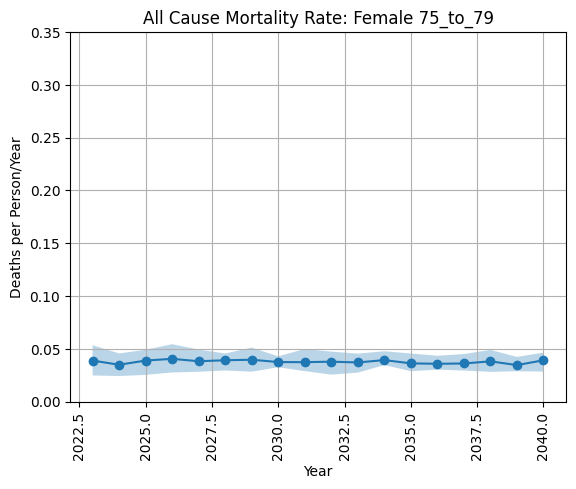

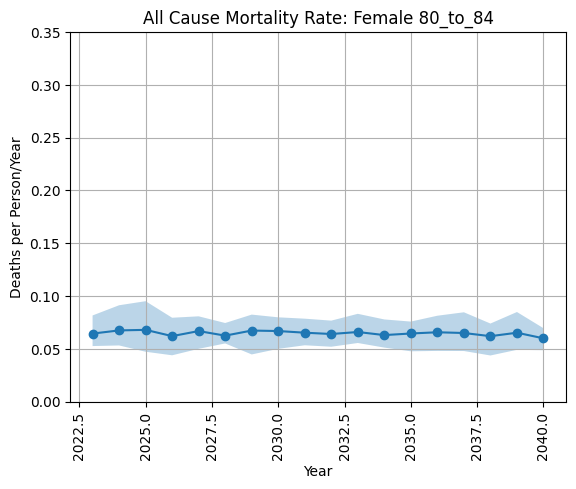

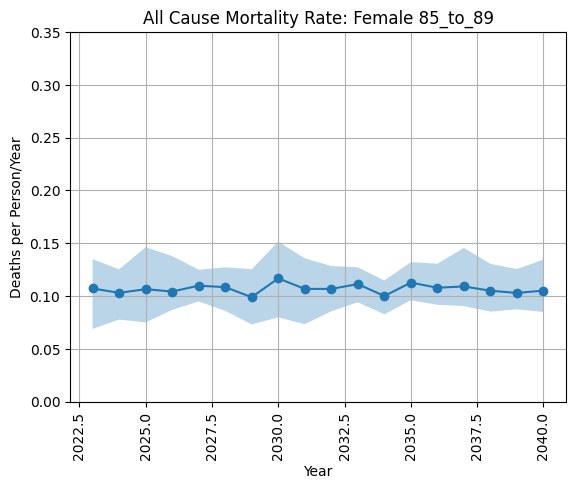

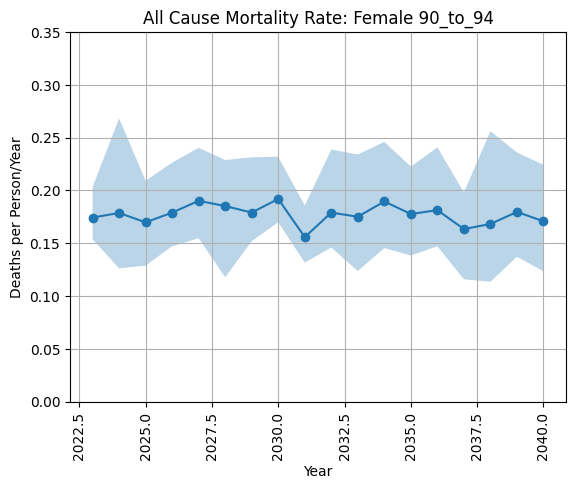

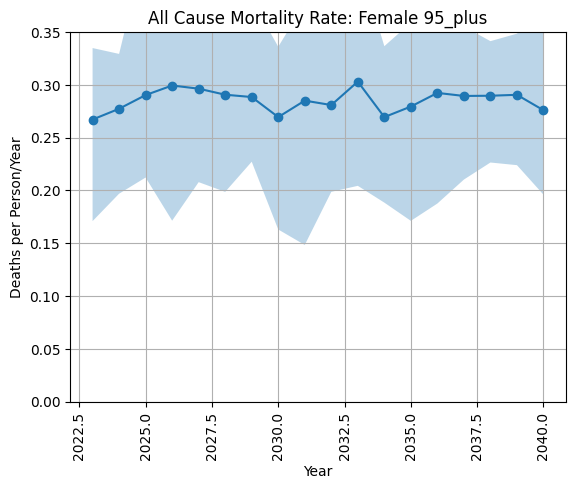

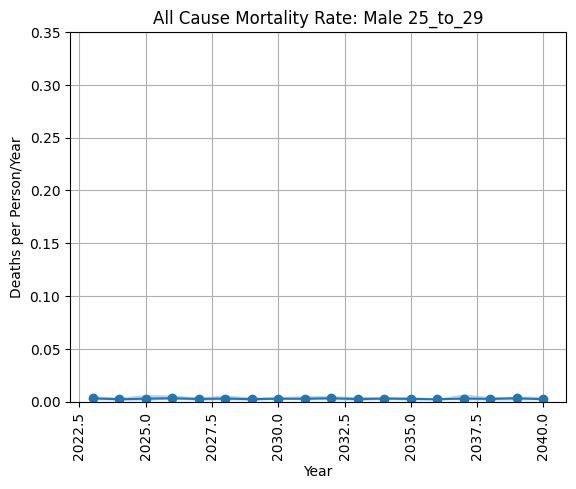

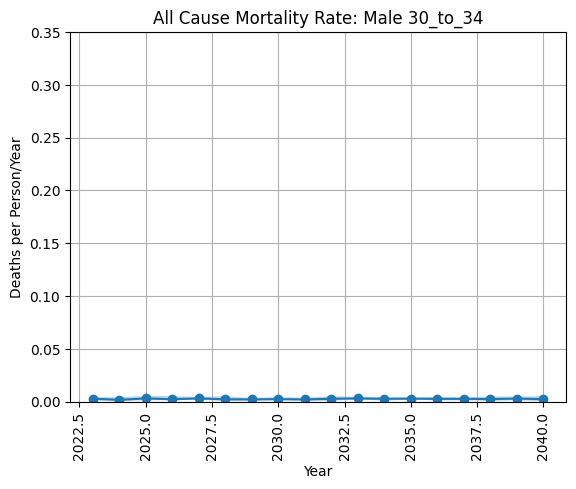

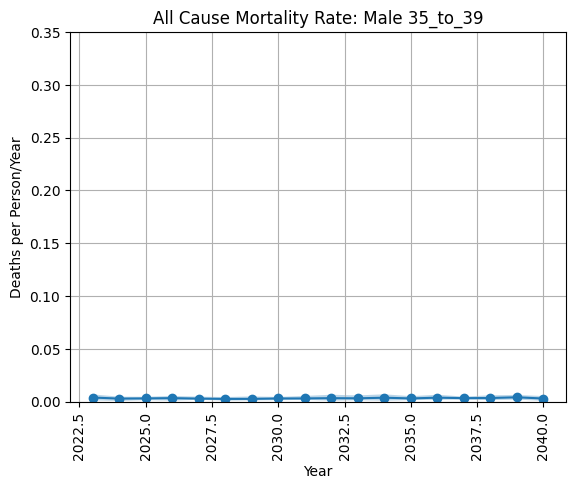

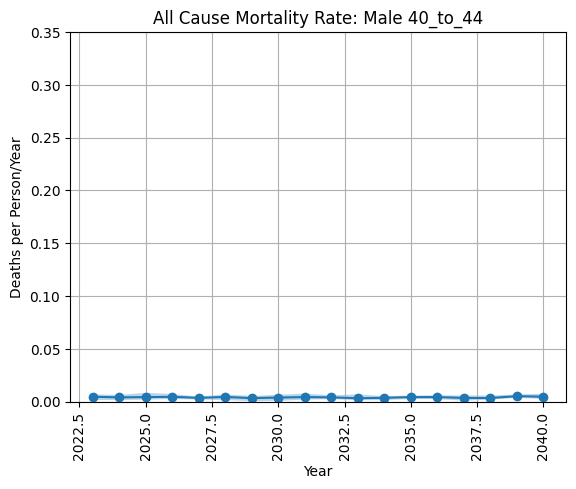

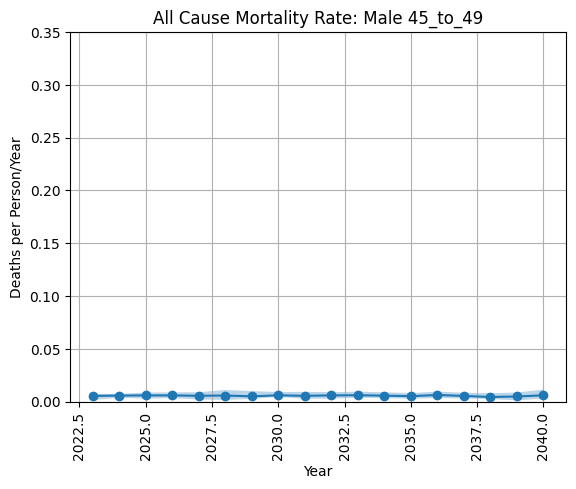

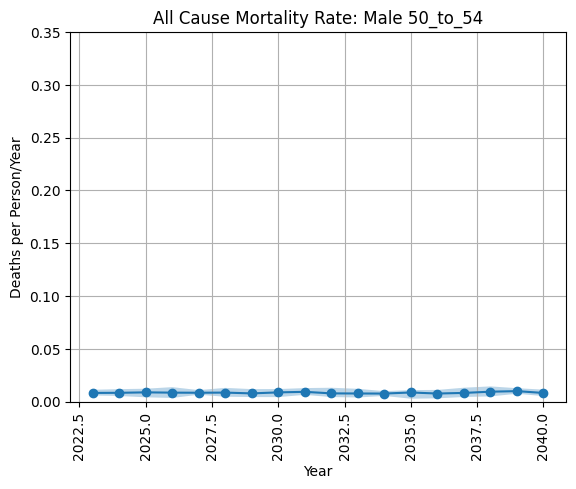

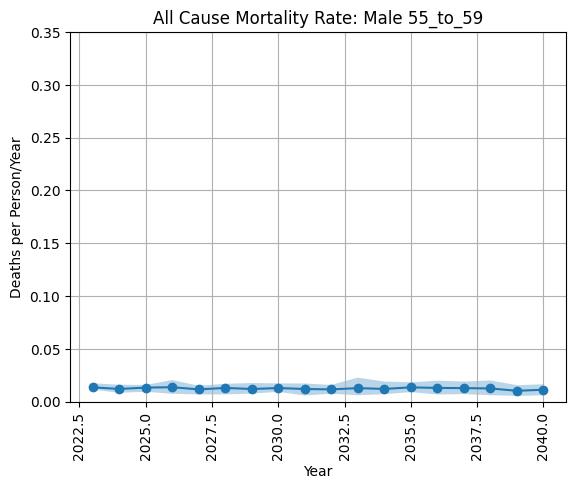

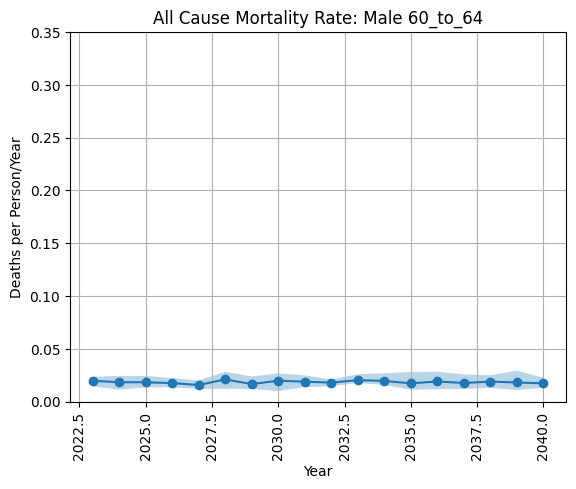

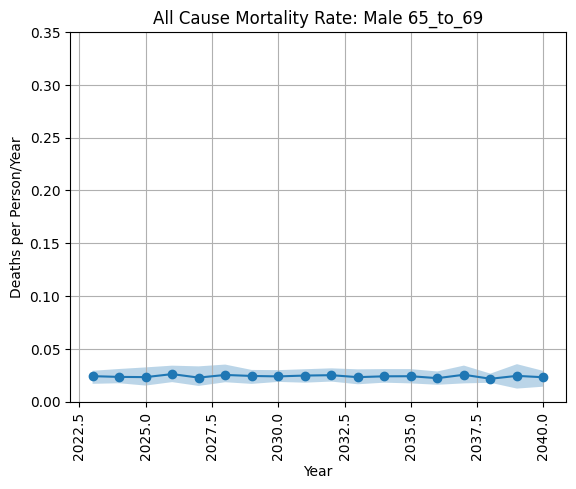

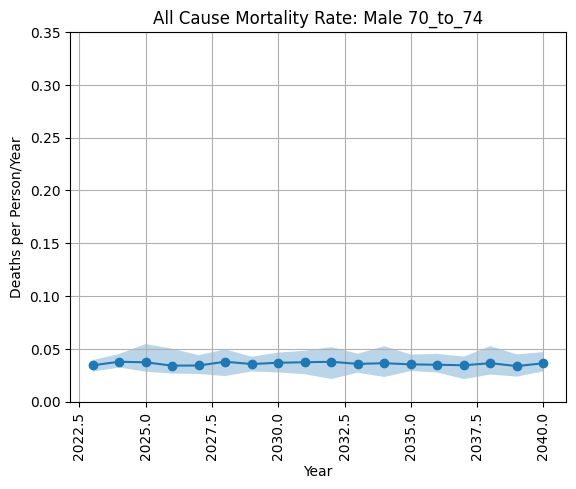

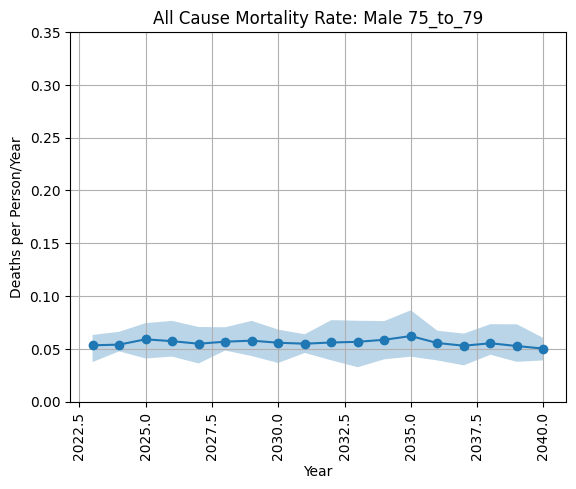

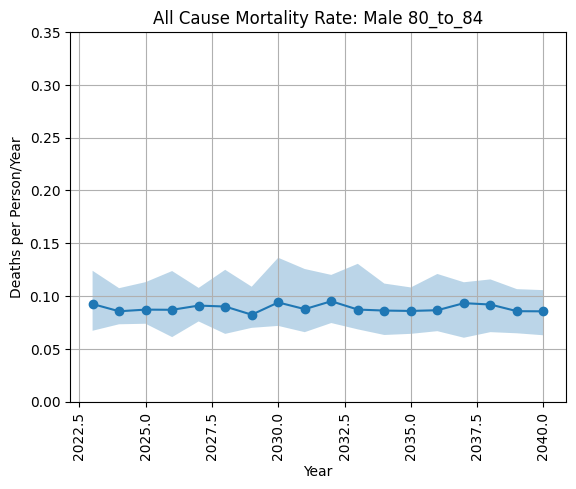

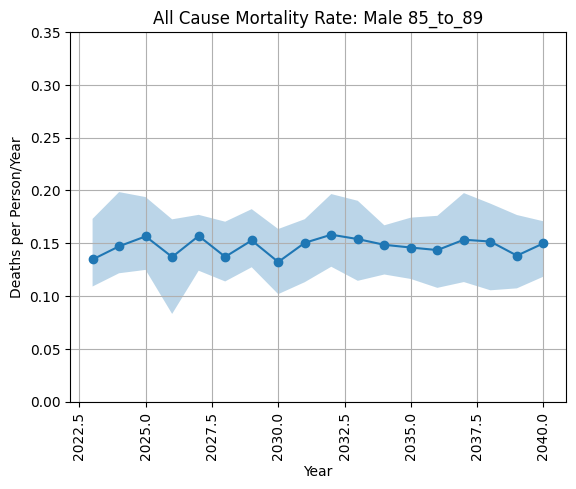

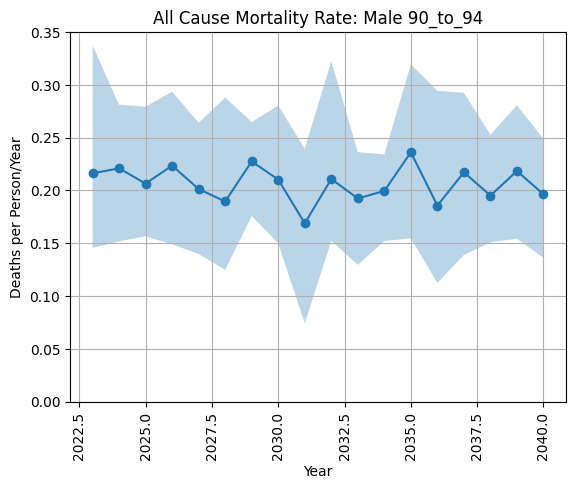

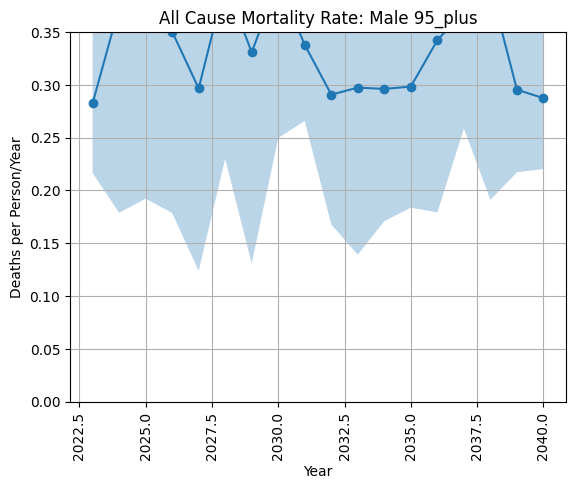

In [36]:
#%%capture 
with PdfPages('ACMR_07212023.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for age in result_summary.age.unique():
            plt.figure() 
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'All Cause Mortality Rate: {sex} {age}') 
            plt.xticks(rotation=90) 
            plt.ylim(0,0.35)
            plt.grid()
            plt.xlabel('Year')
            plt.ylabel('Deaths per Person/Year')
            pdf.savefig(bbox_inches='tight')

## Putting Graphs Side by Side

In [ ]:
plt.subplot(1, 1, 1) # row 1, col 2 index 1
plt.plot(xPoints, y1Points)

In [47]:
result_summary_deaths = result_summary_deaths.rename(columns = {'mean':'mean_deaths', '2.5%':'2.5%_deaths', '97.5%':'97.5%_deaths'})
per_time_summ = per_time_summ.rename(columns = {'mean':'mean_time', '2.5%':'2.5%_time', '97.5%':'97.5%_time'})
result_summary = result_summary.rename(columns = {'mean':'mean_acmr', '2.5%':'2.5%_acmr', '97.5%':'97.5%_acmr'})
all_results = pd.concat([result_summary_deaths,per_time_summ[['mean_time','2.5%_time','97.5%_time']],result_summary[['mean_acmr','2.5%_acmr','97.5%_acmr']]],axis=1)
all_results.head()

,age,sex,year,mean_deaths,2.5%_deaths,97.5%_deaths,mean_time,2.5%_time,97.5%_time,mean_acmr,2.5%_acmr,97.5%_acmr
0,25_to_29,Female,2023,1.9,0.225,5.325,1776.001095,1720.675702,1842.536071,0.001085,0.000123,0.003092
1,25_to_29,Female,2024,2.3,0.000,5.775,1751.278303,1706.434223,1810.641752,0.001309,0.000000,0.003320
2,25_to_29,Female,2025,1.3,0.000,3.775,1742.853388,1708.168652,1792.203149,0.000747,0.000000,0.002189
3,25_to_29,Female,2026,2.8,1.225,6.325,1743.627652,1717.689802,1790.367146,0.001610,0.000685,0.003638
4,25_to_29,Female,2027,1.7,0.000,4.000,1746.540726,1707.547707,1795.982478,0.000980,0.000000,0.002309


In [1]:
with PdfPages('ACMR_comparison_07212023.pdf') as pdf:
    for sex in all_results.sex.unique():
        for age in all_results.age.unique():
            plt.figure()
            plt.suptitle(f'Total Deaths, Person Time and ACMR for {sex} {age}',)
            plt.subplot(1, 3, 1)
            subdata = all_results.loc[(all_results.sex==sex) & (all_results.age==age)]
            plt.plot(subdata['year'], subdata['mean_deaths'], marker='o', label = 'Total Deaths')
            plt.fill_between(subdata['year'], subdata['2.5%_deaths'], subdata['97.5%_deaths'], alpha=.3, label='Total Deaths 95%')
            #plt.title(f'Total Deaths: {sex} {age}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=100)
            plt.grid()
            plt.xlabel('Year')
            plt.ylabel('Total Deaths')
            plt.legend()
            
            plt.subplot(1, 3, 2)
            subdata = all_results.loc[(all_results.sex==sex) & (all_results.age==age)]
            plt.plot(subdata['year'], subdata['mean_time'], marker='o', label = 'Person Time')
            plt.fill_between(subdata['year'], subdata['2.5%_time'], subdata['97.5%_time'], alpha=.3, label='Person Time 95%')
            #plt.title(f'Person Time') 
            plt.xticks(rotation=90) 
            plt.ylim(0,2000)
            plt.grid()
            plt.xlabel('Year')
            plt.ylabel('Person Time')
            plt.legend()
            
            plt.subplot(1, 3, 3)
            subdata = all_results.loc[(all_results.sex==sex) & (all_results.age==age)]
            plt.plot(subdata['year'], subdata['mean_acmr'], marker='o', label = 'ACMR')
            plt.fill_between(subdata['year'], subdata['2.5%_acmr'], subdata['97.5%_acmr'], alpha=.3, label='ACMR 95%')
            #plt.title(f'ACMR') 
            plt.xticks(rotation=90) 
            plt.ylim(0,0.35)
            plt.grid()
            plt.xlabel('Year')
            plt.ylabel('Deaths per Person/Year')
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

            pdf.savefig(bbox_inches='tight')

NameError: name 'PdfPages' is not defined

# New Paneled Graphs with Deaths, Prevalence Count, CSMR and Prevalence Rate

## IHD

#### Deaths

In [14]:
deaths_IHD = deaths.loc[(deaths.year > 2022) & (deaths.cause.isin(['acute_myocardial_infarction','acute_myocardial_infarction_and_heart_failure','heart_failure_from_ischemic_heart_disease','post_myocardial_infarction']))]
deaths_IHD = deaths_IHD.groupby(['sex', 'year','input_draw','scenario']).value.sum().reset_index()
deaths_IHD.head()

,sex,year,input_draw,scenario,value
0,Female,2023,29,baseline,89
1,Female,2023,232,baseline,96
2,Female,2023,357,baseline,83
3,Female,2023,394,baseline,93
4,Female,2023,602,baseline,94


In [15]:
deaths_IHD_summ = (deaths_IHD
                      .groupby(['sex', 'year','scenario'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
deaths_IHD_summ.head()

,sex,year,scenario,mean,2.5%,97.5%
0,Female,2023,baseline,94.9,83.900,107.550
1,Female,2024,baseline,95.0,70.025,116.750
2,Female,2025,baseline,98.2,76.700,120.425
3,Female,2026,baseline,99.6,84.225,123.550
4,Female,2027,baseline,107.7,94.900,126.850


#### IHD Prevalence

In [10]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time_all = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
person_time_IHD = state_person_time.loc[state_person_time['state'].isin(["acute_myocardial_infarction_and_heart_failure", "acute_myocardial_infarction", "heart_failure_from_ischemic_heart_disease","post_myocardial_infarction"])].reset_index() 
person_time_IHD.head()

,index,Unnamed: 0,sex,year,measure,input_draw,scenario,age,state,value
0,15,15,Female,2021,state_person_time,29,baseline,25_to_29,acute_myocardial_infarction_and_heart_failure,0.0
1,16,16,Female,2021,state_person_time,29,baseline,30_to_34,acute_myocardial_infarction_and_heart_failure,0.0
2,17,17,Female,2021,state_person_time,29,baseline,35_to_39,acute_myocardial_infarction_and_heart_failure,0.0
3,18,18,Female,2021,state_person_time,29,baseline,40_to_44,acute_myocardial_infarction_and_heart_failure,0.0
4,19,19,Female,2021,state_person_time,29,baseline,45_to_49,acute_myocardial_infarction_and_heart_failure,0.0


In [17]:
person_time_IHD = person_time_IHD.groupby(['sex', 'year', 'input_draw','scenario']).value.sum().reset_index()
person_time_IHD = person_time_IHD.loc[person_time_IHD.year > 2022].reset_index()
person_time_IHD.head()

,index,sex,year,input_draw,scenario,value
0,0,Female,2023,29,baseline,586.370979
1,1,Female,2023,232,baseline,674.683094
2,2,Female,2023,357,baseline,610.518823
3,3,Female,2023,394,baseline,608.678987
4,4,Female,2023,602,baseline,524.506502


In [19]:
person_time_all = person_time_all.rename(columns = {'value':'ptvalue'})
person_time_all = person_time_all.groupby(['sex', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()
person_time_all = person_time_all.loc[person_time_all.year > 2022].reset_index()
person_time_all.head()

,index,sex,year,input_draw,scenario,ptvalue
0,0,Female,2023,29,baseline,19184.580424
1,1,Female,2023,232,baseline,19003.049966
2,2,Female,2023,357,baseline,19152.229979
3,3,Female,2023,394,baseline,19213.174538
4,4,Female,2023,602,baseline,19176.991102


In [20]:
person_time_IHD_summ = (person_time_IHD
                      .groupby(['sex', 'year','scenario'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
person_time_IHD_summ.head()

,sex,year,scenario,mean,2.5%,97.5%
0,Female,2023,baseline,617.901164,538.426010,699.685695
1,Female,2024,baseline,639.212594,559.672279,698.725530
2,Female,2025,baseline,653.042026,586.829021,704.101300
3,Female,2026,baseline,669.332238,613.696372,704.559343
4,Female,2027,baseline,681.045859,612.983436,723.565229


#### CSMR 

In [21]:
csmr_ihd = pd.concat([deaths_IHD, person_time_all.ptvalue], axis=1)
csmr_ihd['mean_rate'] = csmr_ihd['value'] / csmr_ihd['ptvalue']
csmr_ihd_summ = (csmr_ihd
                      .groupby(['sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

csmr_ihd_summ.head()

,sex,year,scenario,mean,2.5%,97.5%
0,Female,2023,baseline,0.004970,0.004383,0.005635
1,Female,2024,baseline,0.004964,0.003644,0.006110
2,Female,2025,baseline,0.005116,0.003974,0.006266
3,Female,2026,baseline,0.005180,0.004352,0.006427
4,Female,2027,baseline,0.005588,0.004894,0.006653


#### Prevalence Rates

In [22]:
prev_IHD = pd.concat([person_time_IHD, person_time_all.ptvalue], axis=1)
prev_IHD['mean_rate'] = prev_IHD['value'] / prev_IHD['ptvalue']
prev_IHD_summ = (prev_IHD
                      .groupby(['sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

prev_IHD_summ.head()

,sex,year,scenario,mean,2.5%,97.5%
0,Female,2023,baseline,0.032366,0.028074,0.036658
1,Female,2024,baseline,0.033395,0.029107,0.036601
2,Female,2025,baseline,0.034022,0.030446,0.036813
3,Female,2026,baseline,0.034795,0.031797,0.036758
4,Female,2027,baseline,0.035325,0.031709,0.037568


#### Making a Plot

In [23]:
deaths_IHD_summ = deaths_IHD_summ.rename(columns = {'mean':'mean_IHD_death', '2.5%':'2.5%_IHD_deaths', '97.5%':'97.5%_IHD_deaths'})
csmr_ihd_summ = csmr_ihd_summ.rename(columns = {'mean':'mean_csmr', '2.5%':'2.5%_csmr', '97.5%':'97.5%_csmr'})
person_time_IHD_summ = person_time_IHD_summ.rename(columns = {'mean':'mean_prev_count', '2.5%':'2.5%_prev_count', '97.5%':'97.5%_prev_count'})
prev_IHD_summ = prev_IHD_summ.rename(columns = {'mean':'mean_prev_rate', '2.5%':'2.5%_prev_rate', '97.5%':'97.5%_prev_rate'})
all_results = pd.concat([deaths_IHD_summ,csmr_ihd_summ[['mean_csmr','2.5%_csmr','97.5%_csmr']],person_time_IHD_summ[['mean_prev_count','2.5%_prev_count','97.5%_prev_count']],prev_IHD_summ[['mean_prev_rate','2.5%_prev_rate','97.5%_prev_rate']]],axis=1)
all_results.head()

,sex,year,scenario,mean_IHD_death,2.5%_IHD_deaths,97.5%_IHD_deaths,mean_csmr,2.5%_csmr,97.5%_csmr,mean_prev_count,2.5%_prev_count,97.5%_prev_count,mean_prev_rate,2.5%_prev_rate,97.5%_prev_rate
0,Female,2023,baseline,94.9,83.900,107.550,0.004970,0.004383,0.005635,617.901164,538.426010,699.685695,0.032366,0.028074,0.036658
1,Female,2024,baseline,95.0,70.025,116.750,0.004964,0.003644,0.006110,639.212594,559.672279,698.725530,0.033395,0.029107,0.036601
2,Female,2025,baseline,98.2,76.700,120.425,0.005116,0.003974,0.006266,653.042026,586.829021,704.101300,0.034022,0.030446,0.036813
3,Female,2026,baseline,99.6,84.225,123.550,0.005180,0.004352,0.006427,669.332238,613.696372,704.559343,0.034795,0.031797,0.036758
4,Female,2027,baseline,107.7,94.900,126.850,0.005588,0.004894,0.006653,681.045859,612.983436,723.565229,0.035325,0.031709,0.037568


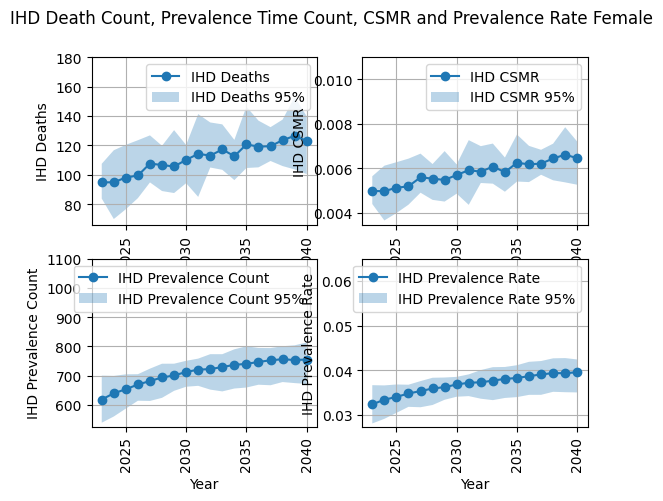

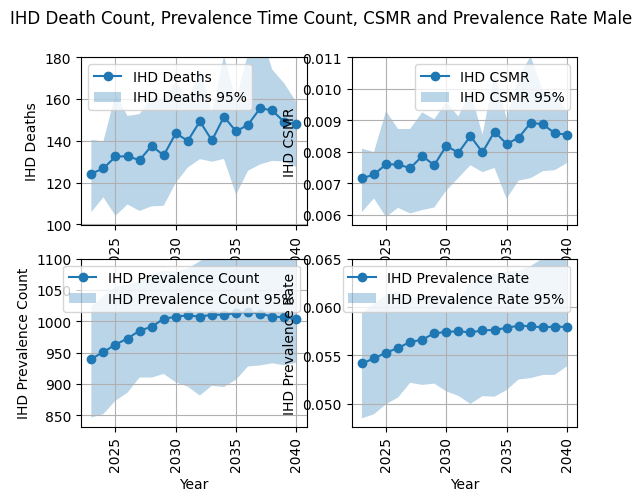

In [28]:
with PdfPages('deaths_csmr_prev_prev_rate_08022023.pdf') as pdf:
    for sex in all_results.sex.unique():
        plt.figure()
        plt.suptitle(f'IHD Death Count, Prevalence Time Count, CSMR and Prevalence Rate {sex}',)

        plt.subplot(2, 2, 1)
        subdata = all_results.loc[(all_results.sex==sex)]
        plt.plot(subdata['year'], subdata['mean_IHD_death'], marker='o', label = 'IHD Deaths')
        plt.fill_between(subdata['year'], subdata['2.5%_IHD_deaths'], subdata['97.5%_IHD_deaths'], alpha=.3, label='IHD Deaths 95%')
        #plt.title(f'Total Deaths: {sex} {age}') 
        plt.xticks(rotation=90) 
        plt.ylim(ymax=180)
        plt.grid()
        plt.xlabel('Year')
        plt.ylabel('IHD Deaths')
        plt.legend()
            
        plt.subplot(2, 2, 2)
        subdata = all_results.loc[(all_results.sex==sex)]
        plt.plot(subdata['year'], subdata['mean_csmr'], marker='o', label = 'IHD CSMR')
        plt.fill_between(subdata['year'], subdata['2.5%_csmr'], subdata['97.5%_csmr'], alpha=.3, label='IHD CSMR 95%')
        #plt.title(f'Total Deaths: {sex} {age}') 
        plt.xticks(rotation=90) 
        plt.ylim(ymax=0.011)
        plt.grid()
        plt.xlabel('Year')
        plt.ylabel('IHD CSMR')
        plt.legend()

        plt.subplot(2, 2, 3)
        subdata = all_results.loc[(all_results.sex==sex)]
        plt.plot(subdata['year'], subdata['mean_prev_count'], marker='o', label = 'IHD Prevalence Count')
        plt.fill_between(subdata['year'], subdata['2.5%_prev_count'], subdata['97.5%_prev_count'], alpha=.3, label='IHD Prevalence Count 95%')
        #plt.title(f'Total Deaths: {sex} {age}') 
        plt.xticks(rotation=90) 
        plt.ylim(ymax=1100)
        plt.grid()
        plt.xlabel('Year')
        plt.ylabel('IHD Prevalence Count')
        plt.legend()

        plt.subplot(2, 2, 4)
        subdata = all_results.loc[(all_results.sex==sex)]
        plt.plot(subdata['year'], subdata['mean_prev_rate'], marker='o', label = 'IHD Prevalence Rate')
        plt.fill_between(subdata['year'], subdata['2.5%_prev_rate'], subdata['97.5%_prev_rate'], alpha=.3, label='IHD Prevalence Rate 95%')
        #plt.title(f'Total Deaths: {sex} {age}') 
        plt.xticks(rotation=90) 
        plt.ylim(ymax=0.065)
        plt.grid()
        plt.xlabel('Year')
        plt.ylabel('IHD Prevalence Rate')
        plt.legend()

        pdf.savefig(bbox_inches='tight')